<a href="https://colab.research.google.com/github/hkevincho/Pison/blob/main/Pison_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PISON Technical Challenge

## Setup

In [1]:
# Import Packges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler

In [3]:
# !pip install sktime

In [4]:
# !pip install tslearn

     |████████████████████████████████| 793 kB 7.3 MB/s 


## Import Data

In [6]:
col_names = ['timestamp',
             'channel_0_raw',
             'channel_1_raw',
             'channel_0_high_passed',
             'channel_1_high_passed',
             'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_raw = pd.read_csv('/content/drive/MyDrive/Technical_challenge/pison_data_interview_2.csv', names=col_names) # import data
print('data shape:', df_raw.shape)
df_raw.head(3)

data shape: (14981, 17)


,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


## EDA

In [7]:
# Understand df
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14981 entries, 0 to 14980
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              14981 non-null  float64
 1   channel_0_raw          14981 non-null  int64  
 2   channel_1_raw          14981 non-null  int64  
 3   channel_0_high_passed  14981 non-null  int64  
 4   channel_1_high_passed  14981 non-null  int64  
 5   quaternion_x           14981 non-null  float64
 6   quaternion_y           14981 non-null  float64
 7   quaternion_z           14981 non-null  float64
 8   quaternion_w           14981 non-null  float64
 9   gyroscope_x            14981 non-null  float64
 10  gyroscope_y            14981 non-null  float64
 11  gyroscope_z            14981 non-null  float64
 12  accelerometer_x        14981 non-null  float64
 13  accelerometer_y        14981 non-null  float64
 14  accelerometer_z        14981 non-null  float64
 15  bo

In [8]:
# To understand the distribution of each columns
df_raw.describe()

,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
count,1.498100e+04,1.498100e+04,1.498100e+04,14981.000000,1.498100e+04,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000
mean,1.566353e+06,1.253765e+07,1.251263e+07,62.550898,-2.571735e+02,0.263423,0.051271,0.111606,0.444427,6.407260,5.183960,2.237941,0.564972,-10.547218,2.064593,2.003071,1.991456
std,3.096750e+04,4.158465e+05,5.626673e+05,35397.290087,6.523863e+04,0.320534,0.395624,0.588643,0.335159,119.806613,346.986960,110.392775,7.242565,6.138921,6.852529,1.414352,0.815279
min,1.514825e+06,1.040201e+07,1.021268e+07,-422438.000000,-1.053204e+06,-0.897766,-0.777832,-1.000000,0.000000,-481.754550,-1830.891100,-623.763060,-34.382812,-48.960938,-27.765625,0.000000,1.000000
25%,1.538782e+06,1.245908e+07,1.233564e+07,-9221.000000,-1.041900e+04,0.032471,-0.085632,-0.304993,0.107849,-36.425343,-50.077854,-21.709728,-2.011719,-13.261719,-0.542969,1.000000,1.000000
50%,1.566517e+06,1.256078e+07,1.254805e+07,411.000000,3.980000e+02,0.230042,0.072815,0.036194,0.401611,-0.671435,-0.727388,1.678587,-0.363281,-9.816406,1.457031,2.000000,2.000000
75%,1.594422e+06,1.265877e+07,1.269320e+07,9792.000000,1.127500e+04,0.584961,0.329468,0.712097,0.754333,47.727833,50.413570,39.278942,3.582031,-7.398438,5.097656,3.000000,3.000000
max,1.618179e+06,1.419352e+07,1.504110e+07,640848.000000,1.726175e+06,0.905945,0.738708,1.000000,0.999268,427.312380,1828.317300,425.130220,37.671875,7.691406,33.898438,4.000000,3.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f598281b5d0>,
      dtype=object)

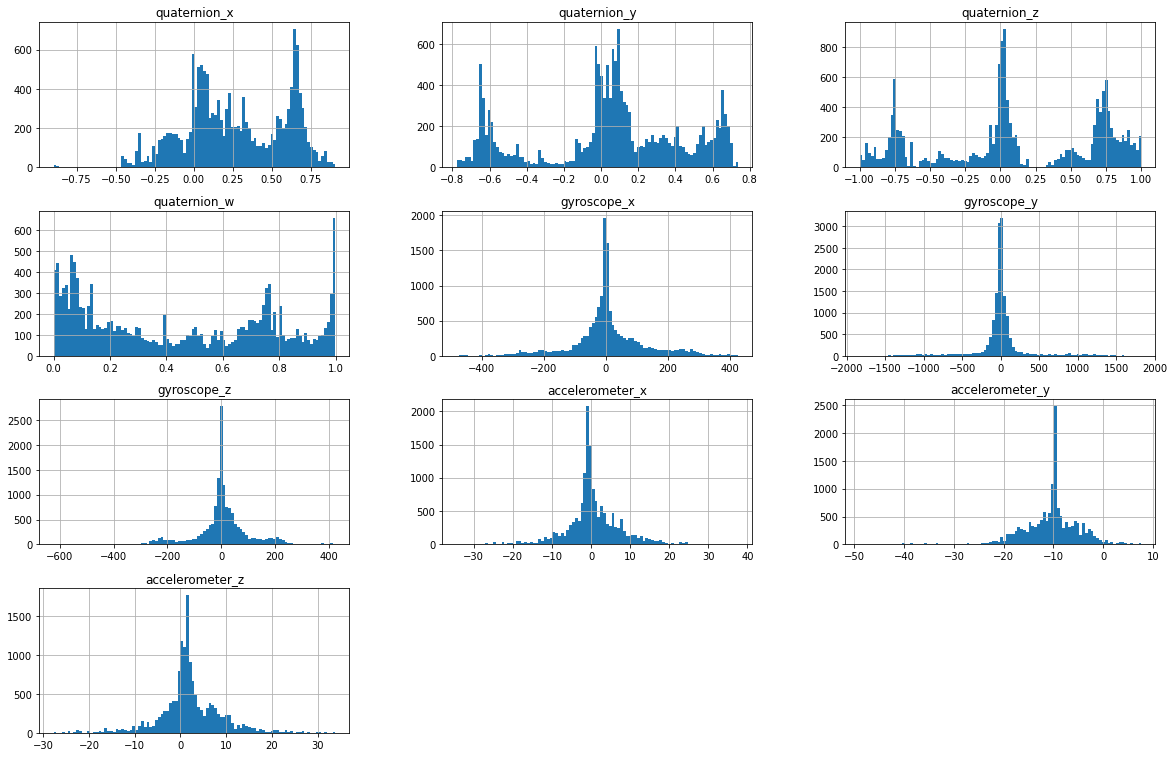

In [9]:
# Histogram of each columns
col_see = [  'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z']
df_raw.hist(column=col_see, bins=100, layout=(6, 3), figsize=(20, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59823f4a10>,
      dtype=object)

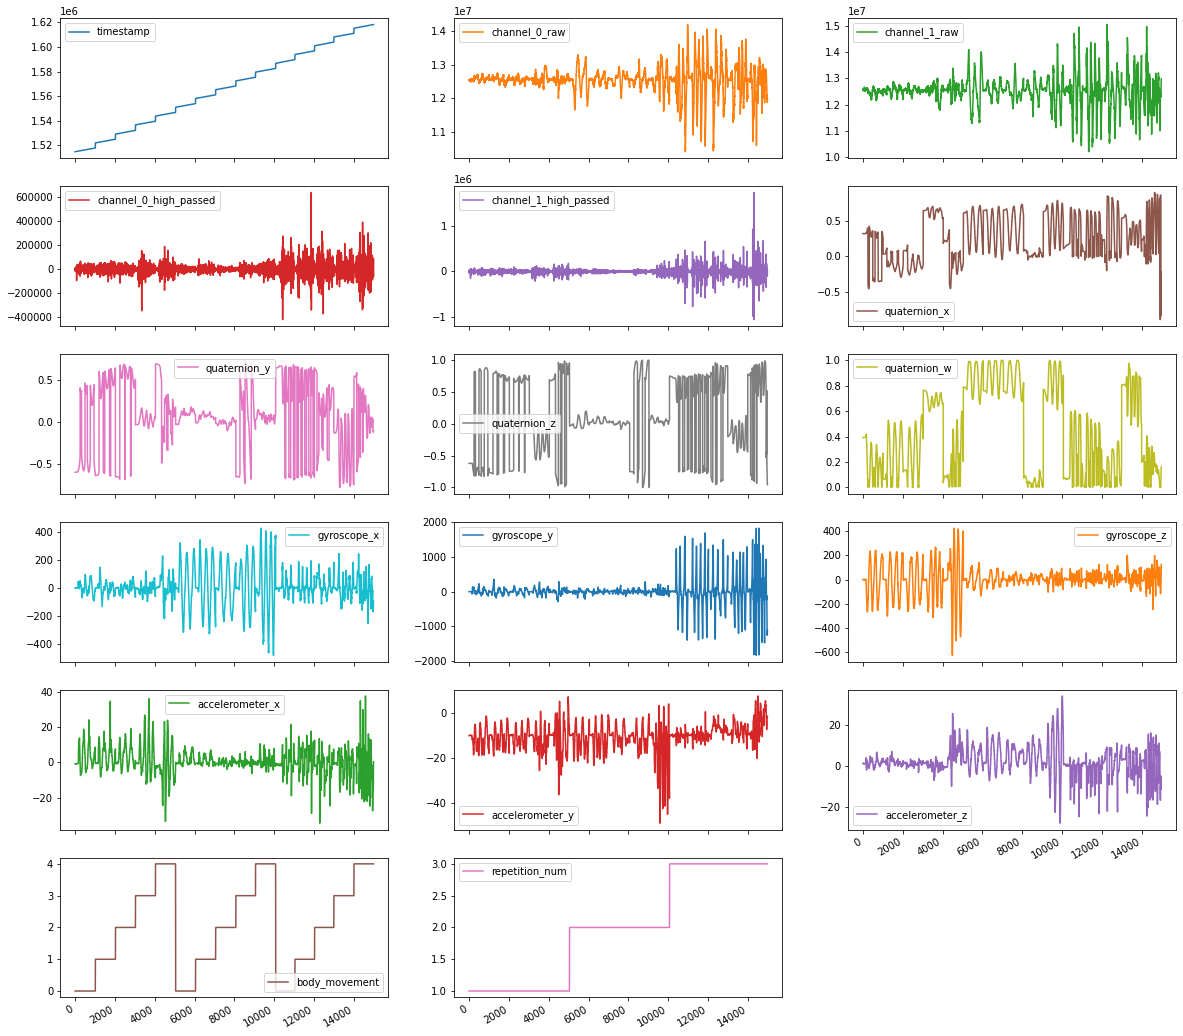

In [10]:
df_raw.plot(subplots=True, layout=(6, 3), figsize=(20, 20))

- The body movement seems to follow repeating pattern. Standing #1, standing #2, walking, walking fast, and running -> Repeat...
- Repetition num lines up with body movement segmentation. First around 5000, and 10,000, then about 15,000

## Data Processing

In [11]:
# Drop non-relevant columns
col_keep = [ 'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_processed = df_raw[col_keep]

In [12]:
# Normalize data using MinMax Scaler
scaler = MinMaxScaler() 
col_scale = ['quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z']
df_processed[col_scale] = pd.DataFrame(scaler.fit_transform(df_processed[col_scale]), columns=df_processed[col_scale].columns)
df_processed.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,0.676232,0.119491,0.189087,0.392377,0.528467,0.500642,0.595167,0.468015,0.687651,0.470037,0,1
1,0.676232,0.119411,0.189087,0.392316,0.528282,0.500673,0.594687,0.468015,0.687651,0.470037,0,1
2,0.676232,0.119411,0.189117,0.392255,0.528590,0.500673,0.594420,0.468015,0.687651,0.470037,0,1
3,0.676232,0.119411,0.189117,0.392255,0.528590,0.500673,0.594420,0.468015,0.687651,0.470037,0,1
4,0.676232,0.119371,0.189117,0.392194,0.528775,0.500581,0.593993,0.468015,0.687651,0.470037,0,1


In [13]:
# Create unique rep and body list
unique_rep = df_raw['repetition_num'].unique()
unique_body = df_raw['body_movement'].unique()

# Define window to calculate time series characteristics
window = 10

# Calculate time series characteristics
appended_df = []
for i in unique_rep:
  for j in unique_body:
    df_temp = df_processed[(df_processed['repetition_num']==i) & (df_processed['body_movement']==j)]
    df_temp.drop(['repetition_num', 'body_movement'], axis=1, inplace=True)

    # Data operation
    df_temp_mean = df_temp.rolling(window).mean()
    df_temp_mean.rename(columns=lambda s: s+'_mean', inplace=True)

    df_temp_range = df_temp.rolling(window).max() - df_temp.rolling(window).min()
    df_temp_range.rename(columns=lambda s: s+'_range', inplace=True)

    df_temp_var = df_temp.rolling(window).var()
    df_temp_var.rename(columns=lambda s: s+'_var', inplace=True)

    # Merge dataframe
    df_merge = pd.concat([df_temp_mean, df_temp_range, df_temp_var], axis=1)

    # Drop nan in window segment
    df_merge = df_merge.iloc[window-1:, :]

    # Append dataframe
    appended_df.append(df_merge)

# Concatenate final df
final_df = pd.concat(appended_df)

final_df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var
9,0.676255,0.119395,0.189102,0.392206,0.528879,0.500537,0.594105,0.467483,0.687913,0.470290,0.000068,0.000121,0.000031,0.000305,0.001416,0.000306,0.001707,0.002656,0.00131,0.001267,1.030538e-09,1.512021e-09,2.589114e-10,8.953463e-09,1.919867e-07,1.810502e-08,3.171012e-07,1.254484e-06,3.051167e-07,2.853601e-07
10,0.676262,0.119383,0.189102,0.392176,0.529002,0.500514,0.593977,0.467218,0.688044,0.470417,0.000068,0.000040,0.000031,0.000244,0.001416,0.000306,0.001227,0.002656,0.00131,0.001267,1.132324e-09,3.782530e-10,2.589114e-10,6.673522e-09,2.307124e-07,1.798812e-08,1.789919e-07,1.646511e-06,4.004657e-07,3.745351e-07
11,0.676269,0.119379,0.189102,0.392151,0.529193,0.500480,0.593881,0.466952,0.688175,0.470544,0.000068,0.000040,0.000031,0.000183,0.001600,0.000336,0.000960,0.002656,0.00131,0.001267,1.132328e-09,2.881927e-10,2.589114e-10,5.015595e-09,2.894323e-07,1.741657e-08,1.198022e-07,1.881726e-06,4.576751e-07,4.280402e-07
12,0.676279,0.119379,0.189099,0.392133,0.529415,0.500414,0.593823,0.466687,0.688306,0.470670,0.000102,0.000040,0.000031,0.000183,0.002216,0.000658,0.000960,0.002656,0.00131,0.001267,1.323143e-09,2.881927e-10,2.485549e-10,4.145124e-09,4.833974e-07,3.249759e-08,8.397855e-08,1.960132e-06,4.767449e-07,4.458752e-07
13,0.676289,0.119379,0.189096,0.392115,0.529636,0.500349,0.593764,0.466421,0.688437,0.470797,0.000102,0.000040,0.000031,0.000122,0.002031,0.000566,0.000533,0.002656,0.00131,0.001267,1.284960e-09,2.881927e-10,2.174855e-10,2.528547e-09,5.682571e-07,3.797145e-08,4.050321e-08,1.881726e-06,4.576751e-07,4.280402e-07
14,0.676299,0.119387,0.189090,0.392102,0.529864,0.500312,0.593748,0.466155,0.688568,0.470924,0.000102,0.000080,0.000061,0.000122,0.002277,0.000566,0.000533,0.002656,0.00131,0.001267,1.017780e-09,7.919638e-10,3.001134e-10,1.865265e-09,6.508017e-07,3.248460e-08,3.490675e-08,1.646511e-06,4.004657e-07,3.745351e-07
15,0.676310,0.119395,0.189084,0.392090,0.530092,0.500275,0.593732,0.465890,0.688699,0.471050,0.000068,0.000080,0.000061,0.000061,0.001970,0.000398,0.000427,0.002656,0.00131,0.001267,5.216021e-10,1.151780e-09,2.999710e-10,8.703620e-10,6.180954e-07,2.400494e-08,2.874116e-08,1.254484e-06,3.051167e-07,2.853601e-07
16,0.676320,0.119407,0.189078,0.392084,0.530307,0.500258,0.593828,0.465624,0.688830,0.471177,0.000068,0.000121,0.000030,0.000061,0.001970,0.000398,0.000907,0.002656,0.00131,0.001267,5.598267e-10,1.961667e-09,2.170583e-10,6.631329e-10,5.989430e-07,2.226172e-08,6.288906e-08,7.056474e-07,1.716282e-07,1.605151e-07
17,0.676323,0.119423,0.189072,0.392084,0.530553,0.500245,0.593993,0.465358,0.688961,0.471304,0.000068,0.000161,0.000061,0.000061,0.002462,0.000398,0.001654,0.000000,0.00000,0.000000,5.216563e-10,3.257709e-09,4.653284e-10,6.631329e-10,6.359850e-07,2.083545e-08,2.206966e-07,0.000000e+00,0.000000e+00,0.000000e+00
18,0.676326,0.119439,0.189066,0.392084,0.530800,0.500231,0.594159,0.465358,0.688961,0.471304,0.000068,0.000161,0.000061,0.000061,0.002031,0.000398,0.001440,0.000000,0.00000,0.000000,4.580446e-10,3.977742e-09,6.308553e-10,6.631329e-10,5.383289e-07,1.898832e-08,3.177335e-07,0.000000e+00,0.000000e+00,0.000000e+00


In [15]:
# Check df shape
final_df.shape # this is correct as 14981 - 14846 = 135. 9*15 = 135 which is what is missing when doing rolling window of 10

(14846, 30)

In [16]:
# Check that there is no NaN
final_df[final_df.isna().any(axis=1)]

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var


## Model Approach 1
Extract time series characteristics and apply Kmeans with Euclidean distance

In [17]:
from sklearn.cluster import KMeans, SpectralClustering

In [24]:
# Perform PCA to two dimensions to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=5) # n_comp = 2 because first two pc explain most variance and also then can be visualized in 2D graph
reduced_data = pca.fit_transform(final_df)


CumSum

array([0.34661894, 0.62926865, 0.71435745, 0.77166363, 0.82604377,
       0.86596039, 0.89261687, 0.91399913, 0.93494382, 0.95228152])

Five PCs will give you 82% of the variance (rule of thumb to be > 80%)

Text(0, 0.5, 'WCSS')

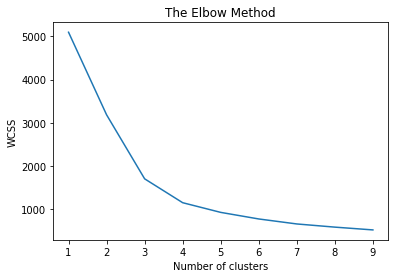

In [25]:
# Perform KMeans and see elbow graph using reduced_data
wcss=[] # within-cluster sum of square
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(reduced_data)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

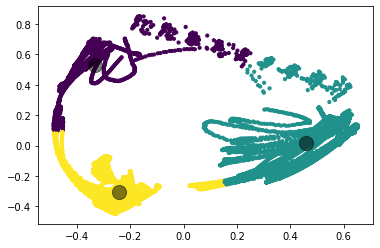

In [23]:
# Visualizing clusters from reduced data using kmeans
kmeans = KMeans(n_clusters=3) # n=3 chosen from elbow method
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [26]:
# Performing Kmeans with 5 PCs
# Perform Kmeans
kmeans = KMeans(n_clusters=4) # n=4 chosen from elbow method
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)
centers = kmeans.cluster_centers_

# Find most similar sample from data
from scipy.spatial import distance

center_list = []
for i in range(len(centers)):
  ary = distance.cdist(reduced_data, centers[i].reshape((1, centers[i].shape[0])), metric='euclidean')

  # Find corresponding min location
  center_num = reduced_data[np.argmin(ary)]

  # Bring back this center to original dimension
  center_num_orig = pca.inverse_transform(center_num)

  # Append
  center_list.append(center_num_orig)

center_df = pd.DataFrame(center_list, columns=final_df.columns)

In [27]:
center_df

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var
0,0.593189,0.131092,0.104447,0.182532,0.516848,0.500586,0.598983,0.517973,0.677473,0.497875,0.011442,0.009950,0.009871,0.020973,0.017438,0.022336,0.021782,0.031941,0.019127,0.019182,0.000448,-0.000034,0.000678,0.000110,0.000082,0.000141,0.000145,0.000739,0.000234,0.000239
1,0.617446,0.839563,0.915515,0.212422,0.555277,0.506088,0.598906,0.463384,0.693404,0.479431,0.020566,-0.002562,-0.006929,0.031394,0.022938,0.032382,0.021894,0.039271,0.027139,0.029581,0.000286,-0.002777,-0.003135,0.000305,0.000143,0.000923,0.000147,0.001392,0.000507,0.000848
2,0.785567,0.554927,0.524583,0.859164,0.555567,0.510271,0.587326,0.490077,0.646625,0.502926,0.018673,0.024138,0.020301,0.019896,0.031854,0.018619,0.018569,0.026082,0.036605,0.029884,-0.000040,0.001687,0.001786,0.000131,0.000204,0.000151,0.000093,0.000598,0.000923,0.000560
3,0.490829,0.504628,0.505957,0.006467,0.509375,0.503988,0.566058,0.560849,0.664465,0.449128,0.147076,0.628096,0.754754,0.065325,0.042710,0.082044,0.040465,0.076016,0.032311,0.061760,0.009799,0.094004,0.125115,0.000777,0.000349,0.002255,0.000290,0.003485,0.000409,0.002317


## Alternative Options Explored

### Visualizing clusters using spectral clustering

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


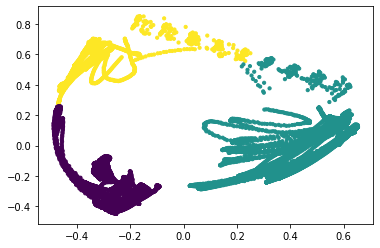

In [65]:
# Visualizing clusters from reduced data using spectral clustering
kmeans = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')
y_kmeans = kmeans.fit_predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=10, cmap='viridis')

### Using t-SNE for dimensionality reduction instead of PCA

In [218]:
# Try using t-distributed stochastic neighbor embedding (t-SNE)
from sklearn.manifold import TSNE

# Project the data
tsne = TSNE(n_components=2, init='random', random_state=0)
reduced_proj = tsne.fit_transform(final_df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0, 0.5, 'WCSS')

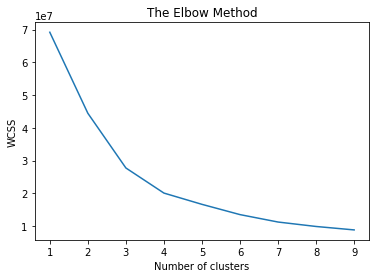

In [80]:
# Determine # of clusters
wcss=[] # within-cluster sum of square
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(reduced_proj)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [239]:
# Silhouette score
from sklearn.metrics import silhouette_score
for i in range(2, 10):
  cluster = KMeans(n_clusters=i, random_state=1)
  cluster_labels = cluster.fit_predict(reduced_proj)
  silhouette_avg = silhouette_score(reduced_proj, cluster_labels)
  print(i, silhouette_avg)

0.3370696
0.37134114
0.36318678
0.334047
0.36693805
0.36530635
0.35427302
0.3582289


The best silhouette score seems to be 3!

In [240]:
# Compute the clusters
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(reduced_proj)

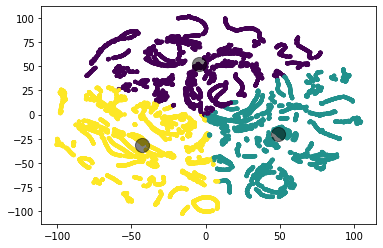

In [241]:
# Visualizing clusters from t-SNE
plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1], c=clusters, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)